# AdventureWorks Sales Explorer

Showcases Cube Alchemy with the AdventureWorks dataset:

- Load Data and build and Hypercube
- Visualize DAG
- Define and reuse metrics and queries
- Execute the queries and visualize results
- Apply filters and visualize again

In [1]:
# Cube Alchemy AdventureWorks Demo
import pandas as pd
from cube_alchemy import Hypercube
import matplotlib.pyplot as plt

In [2]:
# Load AdventureWorks sample tables from GitHub

tables = {}

def clean_currency(x):
    if isinstance(x,str):
        return float(x.replace('$', '').replace(',', ''))
    else:
        return x   


for table in ['Product', 'Region', 'Reseller', 'Sales', 'Salesperson']:
    url = f"https://raw.githubusercontent.com/cube-alchemy/cube-alchemy-examples/main/kaggle/adventureworks/Source/{table}.csv"
    df = pd.read_csv(url, sep='\t')
    for columns in ['Unit Price', 'Cost']:
        if columns in df.columns:
            df[columns] = df[columns].apply(clean_currency)
    tables[table] = df


In [3]:
cube = Hypercube(tables)


Initializing DataModel with provided tables...
Hypercube schema validated successfully. Loading full data..
Hypercube loaded successfully


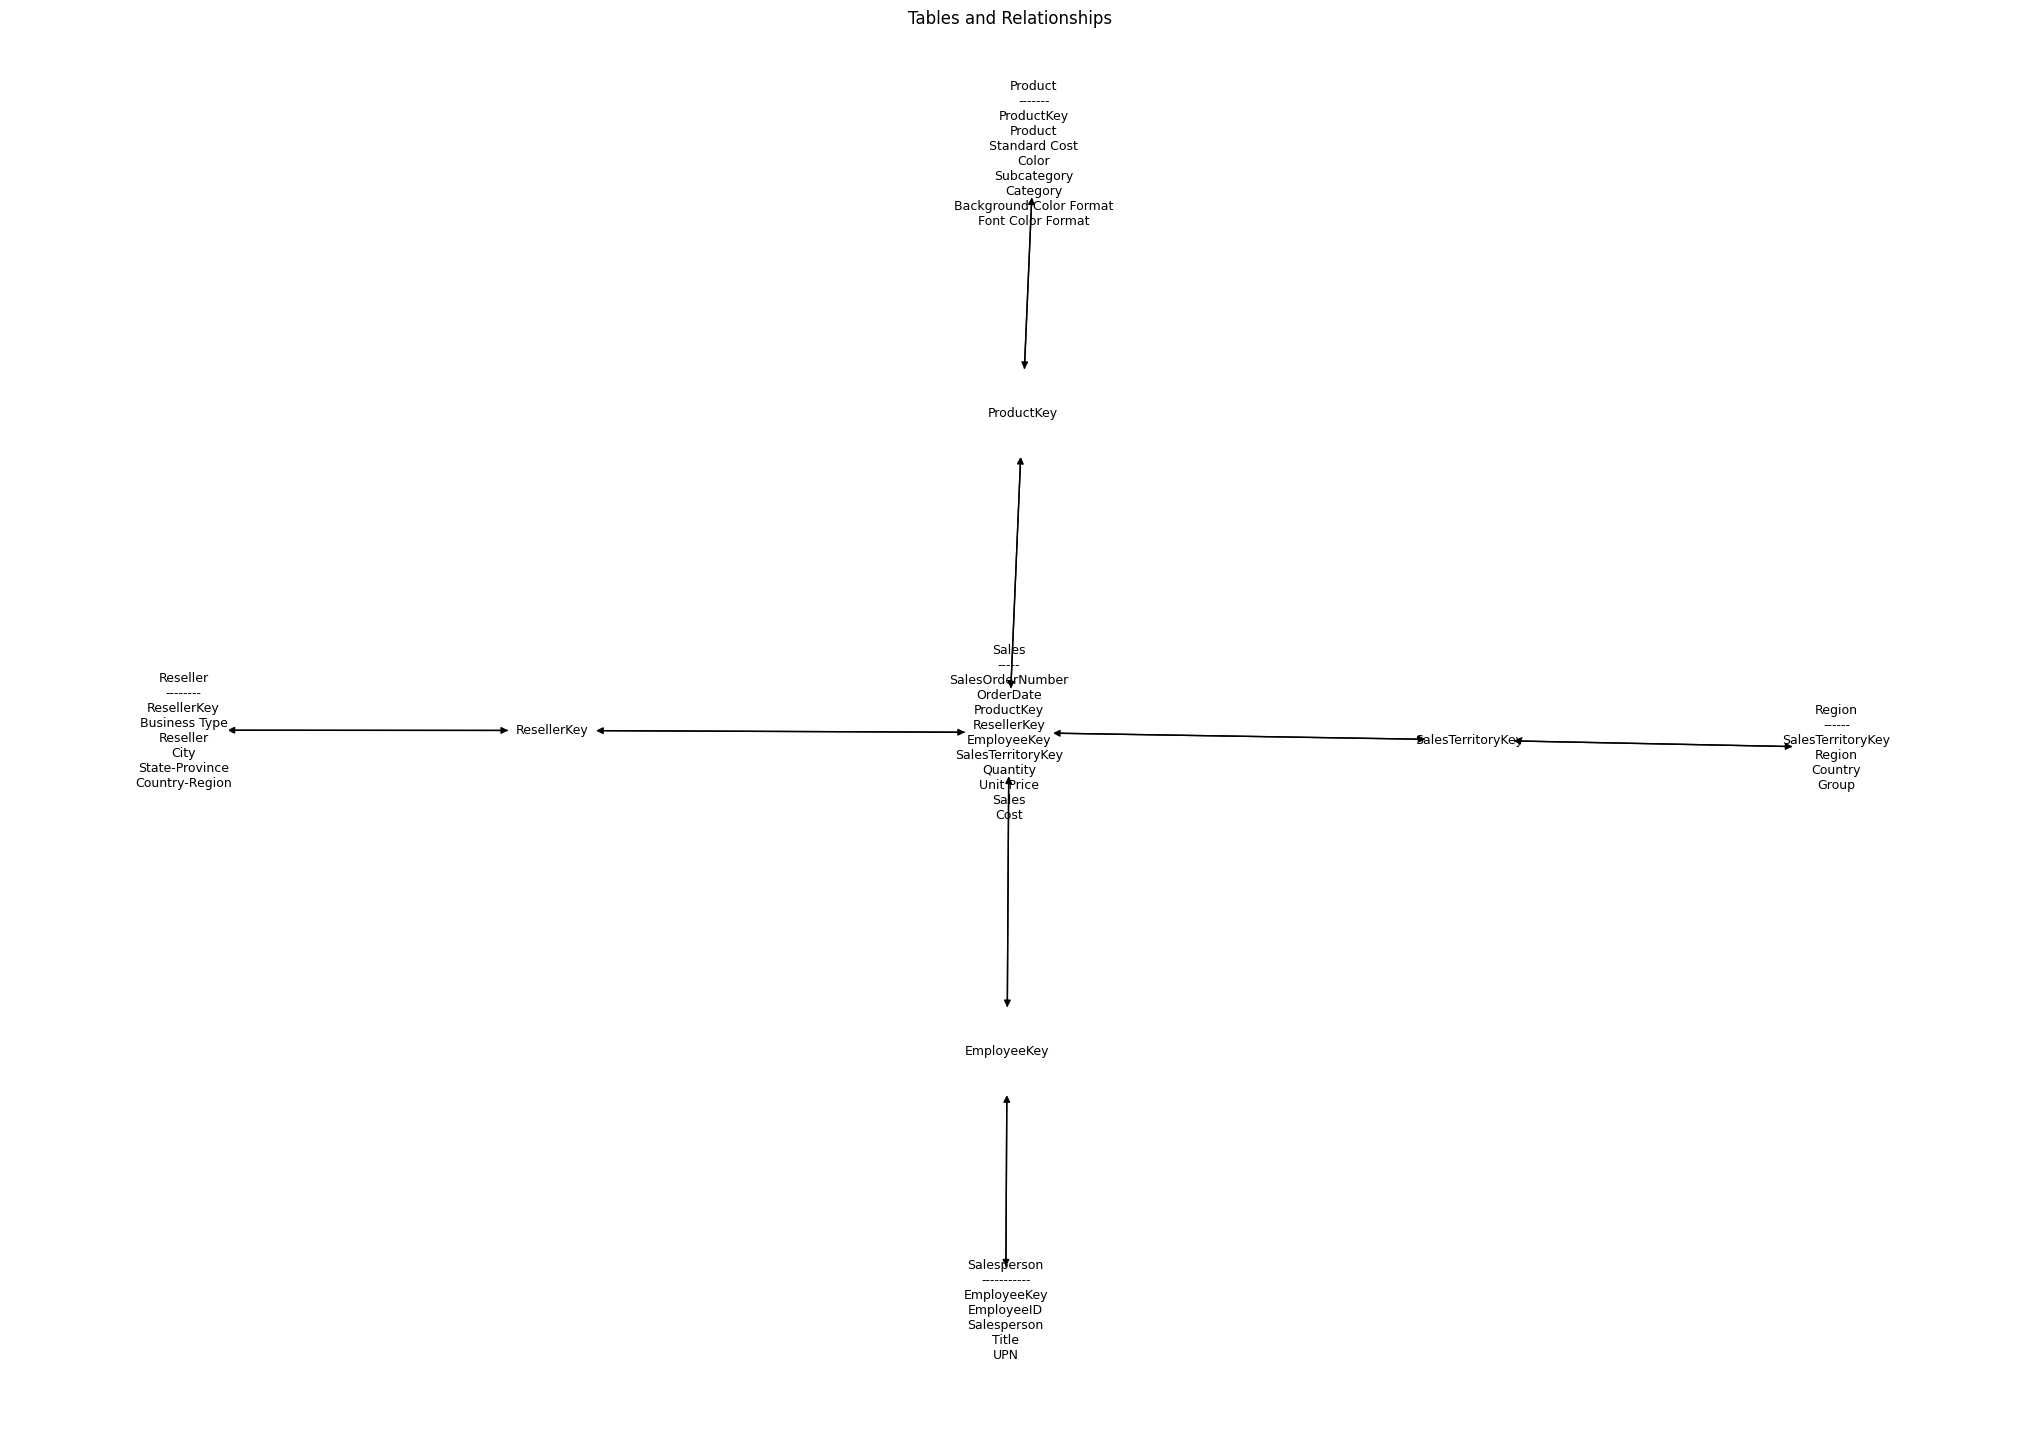

In [4]:
cube.visualize_graph(full_column_names=False)

In [5]:
# Define base metrics and a computed metric
cube.define_metric(name='Revenue', expression='[Unit Price] * [Quantity]', aggregation='sum')
cube.define_metric(name='Total Revenue', expression='[Unit Price] * [Quantity]', aggregation='sum', ignore_dimensions=True)
cube.define_metric(name='Cost',    expression='[Cost]',                 aggregation='sum')
cube.define_metric(name='avg Unit Price', expression='[Unit Price]',    aggregation='mean')

# Distinct orders (lambda function)
cube.define_metric(name='number of Orders', expression='[SalesOrderNumber]', aggregation=lambda x: x.nunique())

# Post-aggregation metric
cube.define_computed_metric(name='Margin', expression='[Revenue] - [Cost]', fillna=0)
cube.define_computed_metric(name='Margin %', expression='100 * ([Revenue] - [Cost]) / [Revenue]')
cube.define_computed_metric(name='Revenue over Total', expression='[Revenue] / [Total Revenue]')

In [6]:
# Define queries
cube.define_query(
    name='Sales by Region and Category',
    metrics=['Revenue'],
    computed_metrics=['Margin %'],
    dimensions=['Region','Category'],
    drop_null_dimensions=True,
    sort=[('Region', 'desc'),('Margin', 'desc')]
)

cube.define_query(
    name='avg Unit Price by Category & Business Type',
    metrics=['avg Unit Price'],
    dimensions=['Category', 'Business Type'],
    drop_null_dimensions=True
)

cube.define_query(
    name='High-Margin Products (>35%)',
    metrics=['number of Orders'],
    computed_metrics=['Margin','Revenue over Total'],
    dimensions=['Product'],
    having='[Margin %] >= 35',
    drop_null_dimensions=True,
    sort=[('Margin', 'desc')]
)

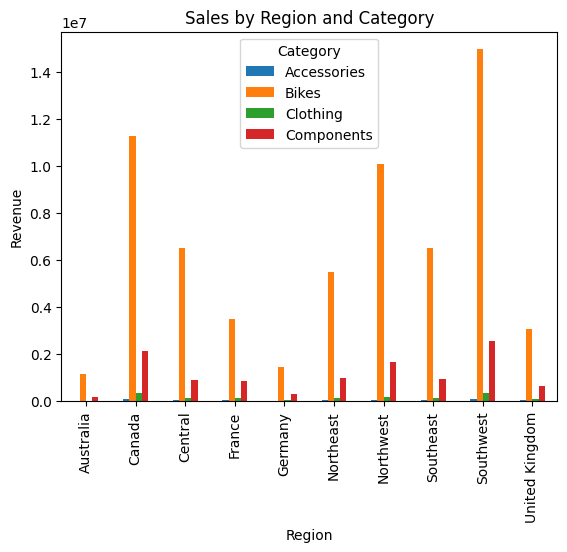

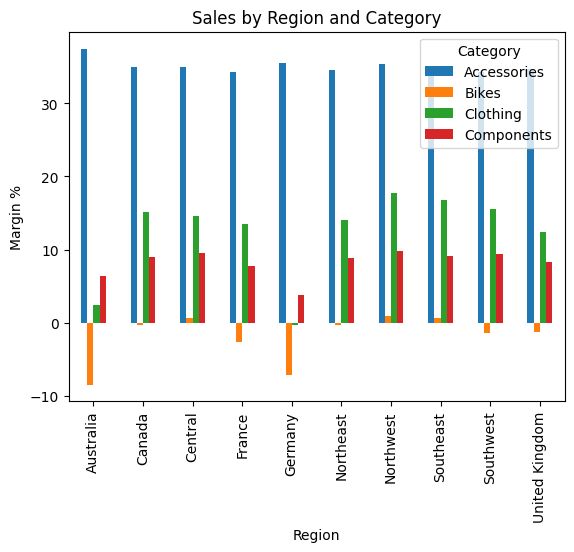

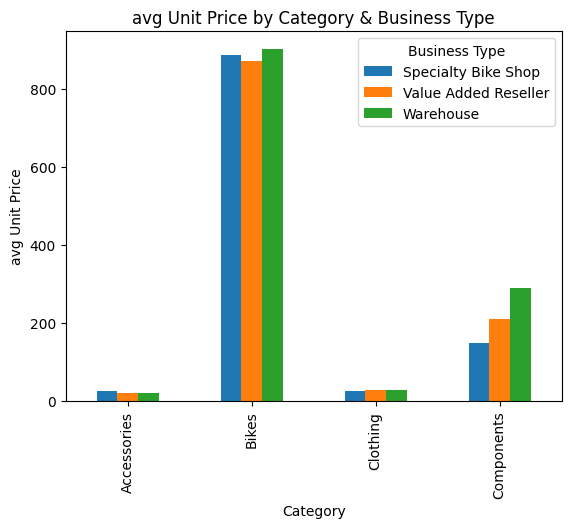

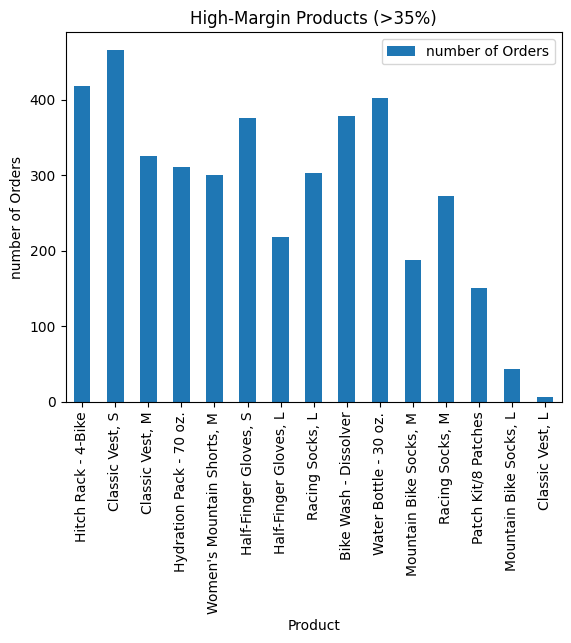

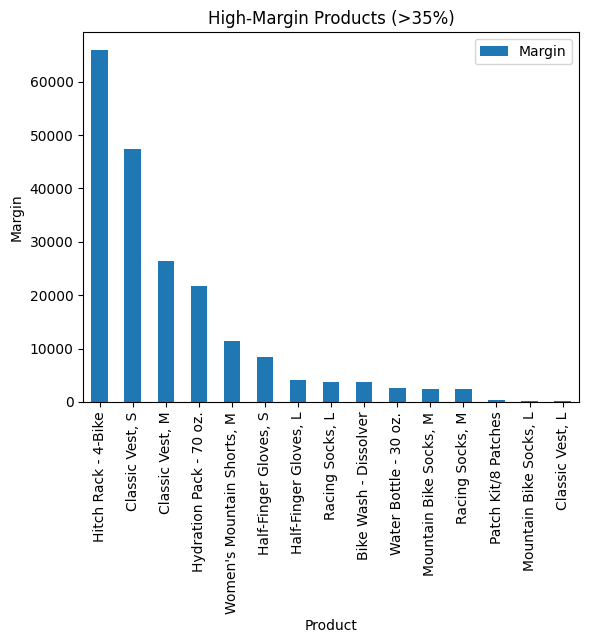

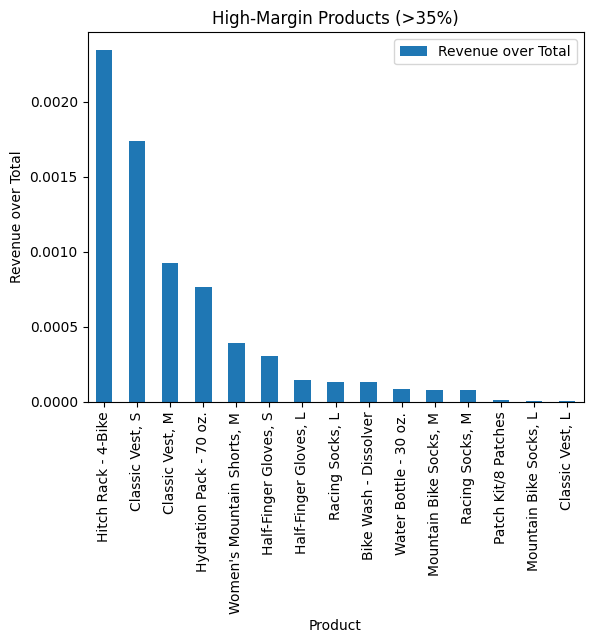

In [7]:
# Define a simple chart and plot everything
def bar_chart(query, dims, measure, sort_by=None, stacked=False):
    df = cube.query(query)[dims + [measure]]
    if isinstance(sort_by,str):
        df = df.sort_values(by=sort_by)
    if len(dims) == 2:
        df = df.pivot_table(index=dims[0], columns=dims[1], values=measure, fill_value=0)
    elif len(dims)== 1:
        df = df.set_index(dims[0])
    else:
        return("max 2 dimensions")
        
    ptl = df.plot(kind='bar', stacked=stacked)
    ptl.set_title(query)
    ptl.set_ylabel(measure)
    ptl.tick_params(axis='x', rotation=90)

    plt.show()

def plot_query(query):
    for measure in cube.queries[query]['metrics'] + cube.queries[query]['computed_metrics']:
        bar_chart(query,cube.queries[query]['dimensions'],measure)

def plot_everything(cube):
    for query in cube.queries:
        plot_query(query)
        

#plot_query('Sales by Region and Category')
plot_everything(cube)

In [8]:
cube.filter({'Category': ['Components','Clothing','Accessories']})
cube.get_filters()

{'Category': ['Components', 'Clothing', 'Accessories']}

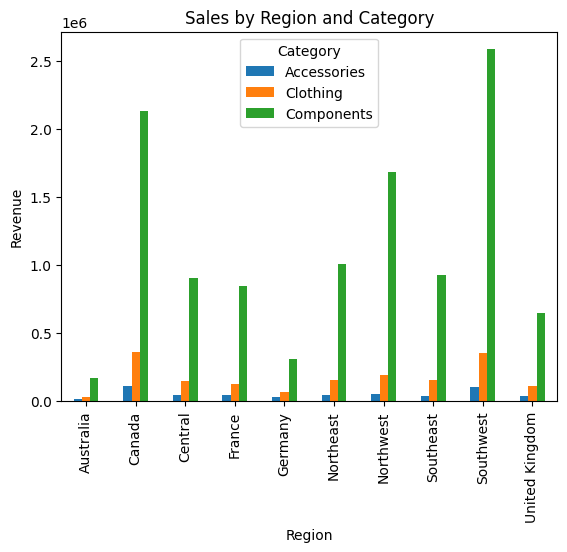

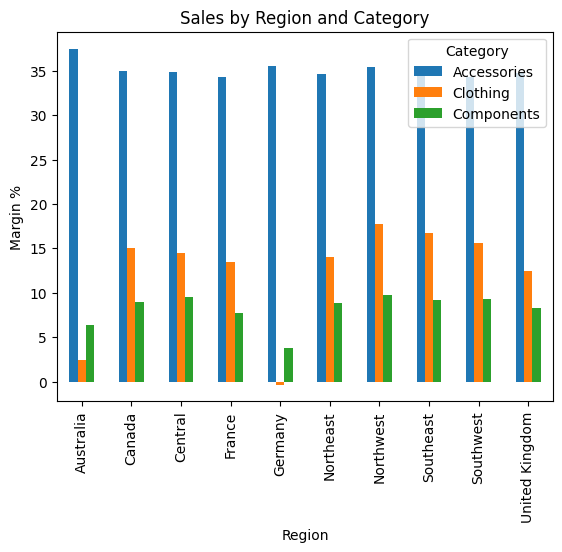

In [9]:
plot_query('Sales by Region and Category')

In [10]:
# Get distinct products, then pick at random and use to filter
#products = cube.dimensions(['Product'])['Product']
products = cube.dimension('Product')
rand_products = products.sample(25, random_state=42).tolist()
cube.filter({'Product':rand_products})
#cube.get_filters()

True

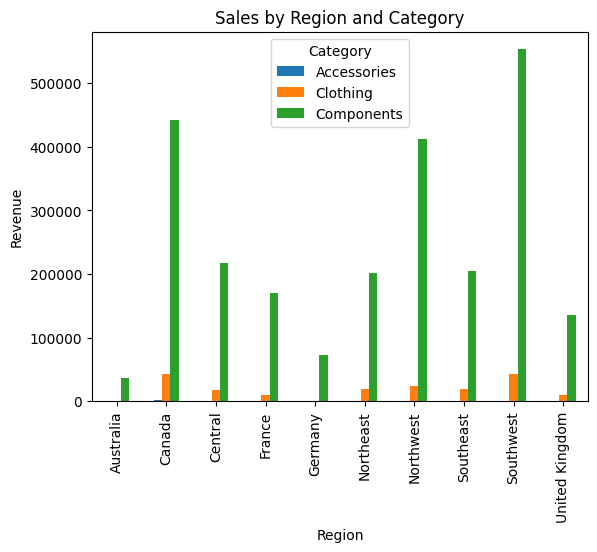

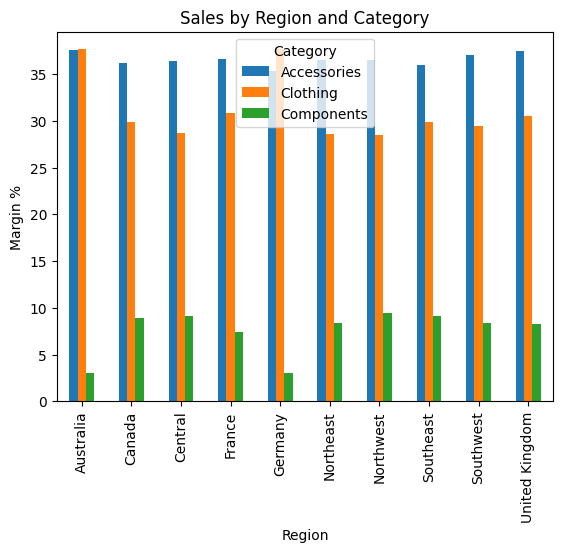

In [11]:
plot_query('Sales by Region and Category')

In [12]:
cube.reset_filters('all')
cube.get_filters()

{}